# Two Resonators + TLS's + Paramp simulation 

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
import numpy as np

In [2]:
from IPython.display import HTML

In [3]:
from matplotlib import animation

In [4]:
from qutip import *
import scipy.linalg as la

## Functions for plotting

We start by defining some function for visualizing the dynamics. We'll use these further down in the notebook. 

In [5]:
def plot_expect_with_variance(N, op_list, op_title, states):
    """
    Plot the expectation value of an operator (list of operators)
    with an envelope that describes the operators variance.
    """
    
    fig, axes = plt.subplots(1, len(op_list), figsize=(14,3))

    for idx, op in enumerate(op_list):
        
        e_op = expect(op, states)
        v_op = variance(op, states)

        axes[idx].fill_between(tlist, e_op - sqrt(v_op), e_op + sqrt(v_op), color="red", alpha=0.5);
        axes[idx].plot(tlist, e_op)
        axes[idx].set_xlabel('Time')
        axes[idx].set_title(op_title[idx])
        axes[idx].set_xlim(0, max(tlist))

    return fig, axes

In [6]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))

    if isket(rho):
        rho = ket2dm(rho)
    
    xvec = linspace(-7.5,7.5,200)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)

    return fig, ax

In [7]:
def plot_wigner_2d_3d(psi):
    #fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))
    fig = plt.figure(figsize=(17, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    plot_wigner(psi, fig=fig, ax=ax);

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    plot_wigner(psi, fig=fig, ax=ax);
    
    plt.close(fig)
    return fig

In [8]:
def plot_fock_distribution_vs_time(tlist, states, fig=None, ax=None):
    
    Z = zeros((len(tlist), states[0].shape[0]))
    
    for state_idx, state in enumerate(states):
        Z[state_idx,:] = real(ket2dm(state).diag())
        
    if fig is None or axes is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,6))

    Y, X = meshgrid(tlist, range(states[0].shape[0]))
    p = ax.pcolor(X, Y, Z.T, norm=mpl.colors.Normalize(0, 0.5), cmap=mpl.cm.get_cmap('rainbow'), edgecolors='k')
    ax.set_xlabel(r'$N$', fontsize=16)
    ax.set_ylabel(r'$t$', fontsize=16)    
    
    cb = fig.colorbar(p)
    cb.set_label('Probability')
    
    return fig, ax

In [9]:
#We need this for codec and visualization of time dynamics

from base64 import b64encode

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
    return HTML(video_tag)

In [10]:
def density_Matrix(phiInitFull):
    return np.kron(phiInitFull, conjugate(phiInitFull)).reshape(size(phiInitFull),size(phiInitFull))

def Partial_Entropy(Vector):
    RHO = density_Matrix(Vector)
    #print(RHO)
    Reduced_matrix = [[RHO[0][0]+RHO[1][1], RHO[0][2]+RHO[1][3]], [RHO[2][0]+RHO[3][1], RHO[2][2]+RHO[3][3]]]
    #print(Reduced_matrix)
    eigvals, eigvecs = la.eig(Reduced_matrix)
    eigvals = real(eigvals)
    nzvals = eigvals[eigvals != 0]
    #print(nzvals)
    logvals = []
    for i in nzvals:
        #print(i)
        logvals.append(log(sqrt(i**2)))
    #print(logvals)
    T = float(real(-sum(nzvals * logvals)))
    return T

## Introduction

The effective Hamiltonian:

$\displaystyle H = \hbar \Delta_1(a^{\dagger}_1a_1+\frac{1}{2}) +  \frac{\hbar}{2} w_{q1} * \sigma_z + \chi * (a_1^{\dagger}a_1 + 1/2) * \sigma_z + \\
~~~~~~~~~\hbar \Delta_2(a^{\dagger}_2a_2+\frac{1}{2}) +  \frac{\hbar}{2} w_{q2} * \sigma_z + \chi * (a_2^{\dagger}a_2 + 1/2) * \sigma_z- \frac{\hbar}{2}p (a^2+a^{\dagger2})$

where $\Delta_{1,2}$ - is the detuning of the oscillator eigenfrequency from the half of pump frequency, $\chi$ - is the dispersive shifts, $w_{q1,2}$ - qubits frequencies in RWA, $p$- is the parametric pump

## Parameters

In [11]:
N = 10

# operators: 
#the annihilation operator of the first resonator
a1 = tensor(destroy(N), qeye(N), qeye(2), qeye(2))
nc1 = a1.dag() * a1
xc1 = a1 + a1.dag()

#the annihilation operator of the second resonator
a2 = tensor(qeye(N), destroy(N), qeye(2), qeye(2))
nc2 = a2.dag() * a2
xc2 = a2 + a2.dag()

# first qubit operators
sm1 = tensor(qeye(N), qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), qeye(N), sigmaz(), qeye(2))
sx1 = tensor(qeye(N), qeye(N), sigmax(), qeye(2))
nq1 = sm1.dag() * sm1
xq1 = sm1 + sm1.dag()

# second qubit operators
sm2 = tensor(qeye(N), qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(N), qeye(2), sigmaz())
sx2 = tensor(qeye(N), qeye(N), qeye(2), sigmax())
nq2 = sm2.dag() * sm2
xq2 = sm2 + sm2.dag()

I = tensor(qeye(N), qeye(N), qeye(2), qeye(2))

# and we'll also need the following operators in calculation of
# expectation values when visualizing the dynamics 

n  = num(N)
x1 = a1 + a1.dag()
p1 = -1j * (a1 - a1.dag())
x2 = a2 + a2.dag()
p2 = -1j * (a2 - a2.dag())

collapce operators

In [12]:
g1 = 0.002        # relaxation rate
g2 = 0.001        # dephasing rate
n_th = 0.1        # bath temperature

##----------------------------------------------------

c_ops = []
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm1)
c_ops.append(np.sqrt(g1 * n_th) * sm1.trans().conj())
c_ops.append(np.sqrt(g2) * sz1)
c_ops.append(np.sqrt(g1 * (1+n_th)) * sm2)
c_ops.append(np.sqrt(g1 * n_th) * sm2.trans().conj())
c_ops.append(np.sqrt(g2) * sz2)

In [13]:
#delta1 = 0.05 * 2 * np.pi
#delta2 = 0.15 * 2 * np.pi

wr1 = 5.1 * 2 * np.pi                        # oscillator frequency in [GHz]
wr2 = 5.2 * 2 * np.pi                        # oscillator frequency in [GHz]
wq  = 140 * 2 * np.pi                        # qubit frequency in [GHz]
chi = 0.03 * 2 * np.pi                       # dispercive shift in [GHz]

pump =  30                                  # Pumping of the system  

tlist = linspace(0, 10, 1001)   # time

In [14]:
a = tensor(destroy(N), destroy(N), qeye(2), qeye(2))

In [22]:
# the Kerr + Paramp Hamiltonian
#H = delta1 * (a1.dag() * a1 + I/2.0) + (wq / 2.0) * sz1 + chi * (a1.dag() * a1 + I/2) * sz1 + delta2 * (a2.dag() * a2 + I/2.0) + (wq / 2.0) * sz2 + chi * (a2.dag() * a2 + I/2) * sz2  - 0.5 * pump * (a1.dag() * a1.dag() + a1 * a1) - 0.5 * pump * (a2.dag() * a2.dag() + a2 * a2)
H = wr1 * (a1.dag() * a1 + I/2.0) + (wq / 2.0) * sz1 + chi * (a1.dag() * a1 + I/2) * sz1 + wr2 * (a2.dag() * a2 + I/2.0) + (wq / 2.0) * sz2 + chi * (a2.dag() * a2 + I/2) * sz2  - 0.5 * pump * (a1.dag() * a1.dag() + a1 * a1) - 0.5 * pump * (a2.dag() * a2.dag() + a2 * a2)
#H = wr1 * (a1.dag() * a1 + I/2.0) + (wq / 2.0) * sz1 + chi * (a1.dag() * a1 + I/2) * sz1 + wr2 * (a2.dag() * a2 + I/2.0) + (wq / 2.0) * sz2 + chi * (a2.dag() * a2 + I/2) * sz2  - 0.5 * pump * (a.dag() * a.dag() + a * a)

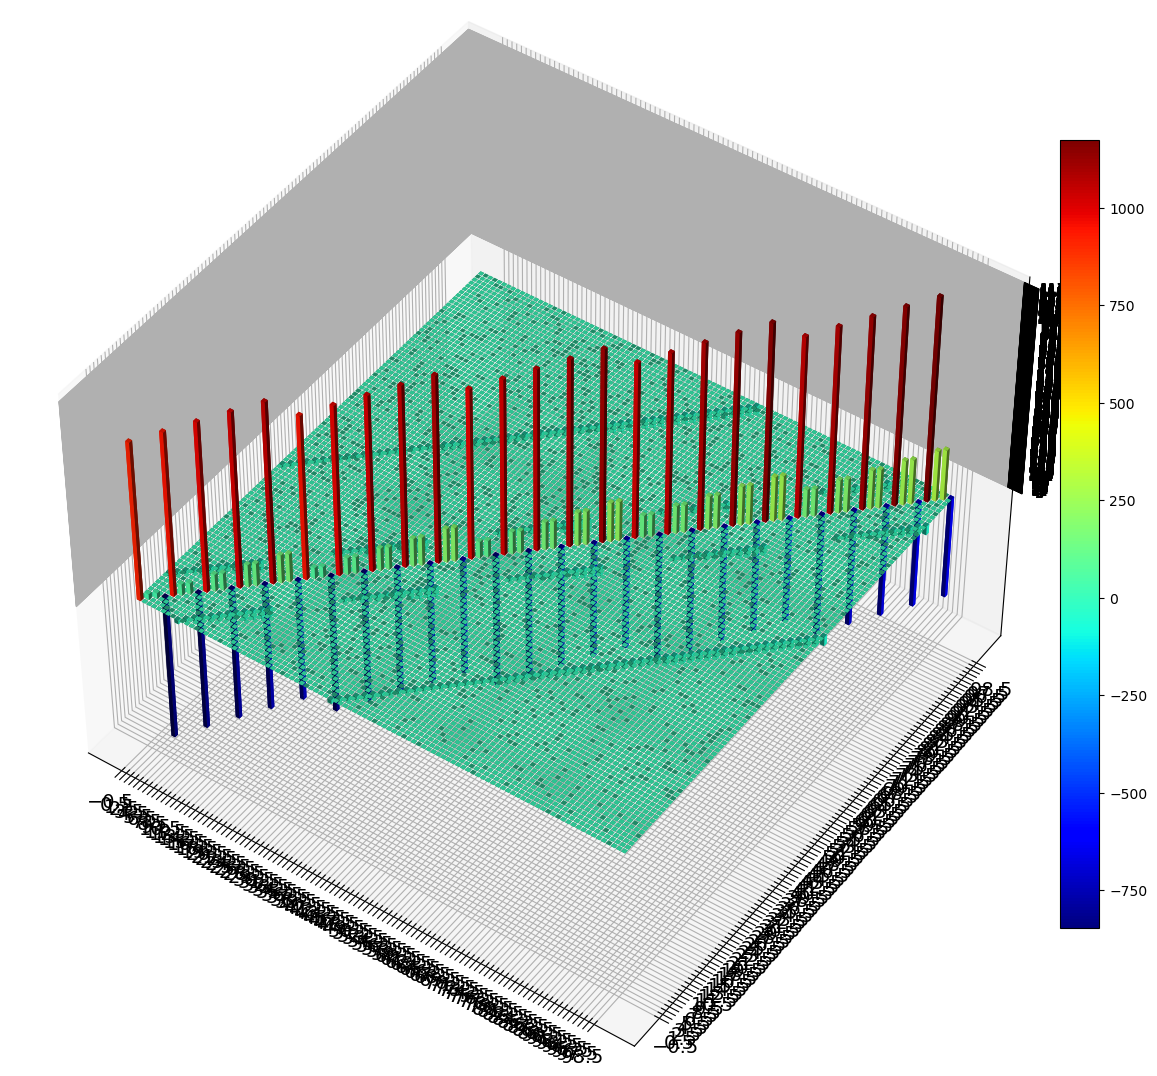

In [88]:
matrix_visualize(H)

## Coherent state

Let's look at how the $\textbf{coherent state}$ evolves under the influence of the Paramp Hamiltonian.

In [101]:
# we start with a coherent state with alpha=2.0
#psi0 = tensor(coherent(N, 0), coherent(N, 0), (basis(2,0)+basis(2,1)).unit(), (basis(2,0)+basis(2,1)).unit())
psi0 = tensor(coherent(N, 2), coherent(N, 2), (basis(2,0)+basis(2,1)).unit(), (basis(2,0)+basis(2,1)).unit())

In [103]:
psi0 = tensor(coherent(N, 2), coherent(N, 2),tensor((basis(2,0)+basis(2,1)).unit(),(basis(2,0)+basis(2,1)).unit()))

In [104]:
psi0

Quantum object: dims = [[10, 10, 2, 2], [1, 1, 1, 1]], shape = (400, 1), type = ket
Qobj data =
[[0.00915774]
 [0.00915774]
 [0.00915774]
 [0.00915774]
 [0.01831592]
 [0.01831592]
 [0.01831592]
 [0.01831592]
 [0.0258999 ]
 [0.0258999 ]
 [0.0258999 ]
 [0.0258999 ]
 [0.02991946]
 [0.02991946]
 [0.02991946]
 [0.02991946]
 [0.02987023]
 [0.02987023]
 [0.02987023]
 [0.02987023]
 [0.02687546]
 [0.02687546]
 [0.02687546]
 [0.02687546]
 [0.02150561]
 [0.02150561]
 [0.02150561]
 [0.02150561]
 [0.01730594]
 [0.01730594]
 [0.01730594]
 [0.01730594]
 [0.01003368]
 [0.01003368]
 [0.01003368]
 [0.01003368]
 [0.0107875 ]
 [0.0107875 ]
 [0.0107875 ]
 [0.0107875 ]
 [0.01831592]
 [0.01831592]
 [0.01831592]
 [0.01831592]
 [0.03663274]
 [0.03663274]
 [0.03663274]
 [0.03663274]
 [0.05180106]
 [0.05180106]
 [0.05180106]
 [0.05180106]
 [0.05984039]
 [0.05984039]
 [0.05984039]
 [0.05984039]
 [0.05974191]
 [0.05974191]
 [0.05974191]
 [0.05974191]
 [0.05375224]
 [0.05375224]
 [0.05375224]
 [0.05375224]
 [0.0430

In [86]:
#test_state = tensor(coherent(N, 1),(basis(2,0)+basis(2,1)).unit(), (basis(2,0)+basis(2,1)).unit())
#test_state = tensor(coherent(N, 1))
#print(test_state)

In [106]:
# and evolve the state under the influence of the hamiltonian. 
# by passing an empty list as expecation value operators argument, 
# we get the full state of the system in result.states
result = mesolve(H, psi0, tlist, [], [])

In [111]:
result.states[150].ptrace(3)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.49994171-6.89708737e-19j -0.07389915-4.19516935e-01j]
 [-0.07389915+4.19516935e-01j  0.50005829-6.79669686e-19j]]

In [50]:
part_trace_entr = []
for i in result.states:
    part_trace_entr.append(Partial_Entropy(i))

KeyboardInterrupt: 

In [166]:
von_neim = []
linear_entr = []
for i in result.states:
    von_neim.append(entropy_vn(i))
    linear_entr.append(entropy_linear(i))

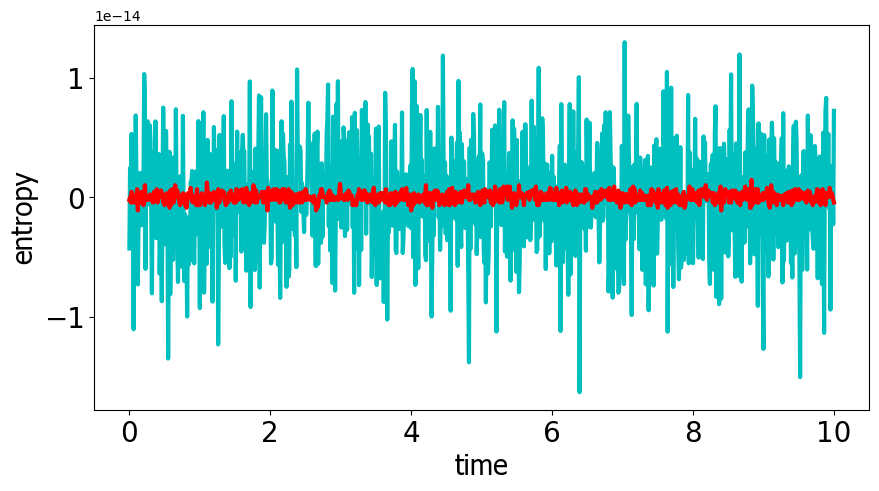

In [167]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(10, 5))

p = axes.plot(tlist, von_neim, 'c', linewidth=3.0)
p = axes.plot(tlist, linear_entr, 'r', linewidth=3.0)

axes.set_xlabel(r'time', fontsize=20, **hfont)
axes.set_ylabel(r'entropy', fontsize=20, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(0, time_steps, 5), 2))
#axes.set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
#axes.set_xlim(0.0,time_steps)

In [179]:
result.states[0][0:4]

array([[0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.01831548+0.j]])

In [180]:
summm = 0
for i in result.states[20][0:4]:
    summm = summm+i
print(summm)

[0.00858626-0.03815397j]


In [181]:
entropy = []

for i in result.states:
    entropy.append(Partial_Entropy(i[0:4]))

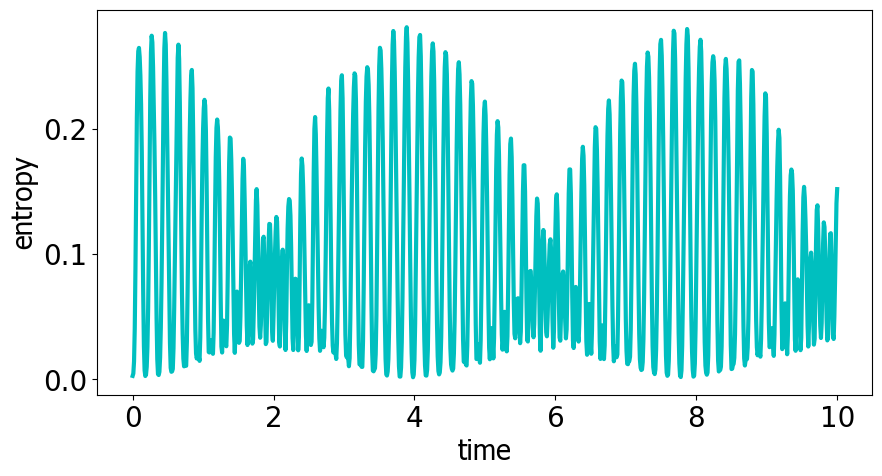

In [182]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(10, 5))

p = axes.plot(tlist, entropy, 'c', linewidth=3.0)
axes.set_xlabel(r'time', fontsize=20, **hfont)
axes.set_ylabel(r'entropy', fontsize=20, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(0, time_steps, 5), 2))
#axes.set_yticks(np.round(np.linspace(0, 0.6, 4), 2))
#axes.set_xlim(0.0,time_steps)

In [155]:
max(entropy)

0.3585662179656815

In [194]:
1/e

0.36787944117144233

In [381]:
2/e

0.7357588823428847

In [383]:
np.log(2)

0.6931471805599453

In [384]:
np.e**(np.e**(-1))

1.444667861009766

In [68]:
def matrix_visualize(matrix):
    # visualize H
    #lbls_list = [[str(d) for d in range(N)], ["u", "d"]]
    #xlabels = []

    #for inds in tomography._index_permutations([len(lbls) for lbls in lbls_list]):
    #     xlabels.append("".join([lbls_list[k][inds[k]]
    #                        for k in range(len(lbls_list))])) 
        
    #fig, ax = matrix_histogram(H, xlabels, xlabels, limits=[-3,10])
    fig, ax = matrix_histogram(matrix)
    ax.view_init(azim=-55, elev=45)
    fig.set_size_inches(18.5, 10.5)
    plt.show()

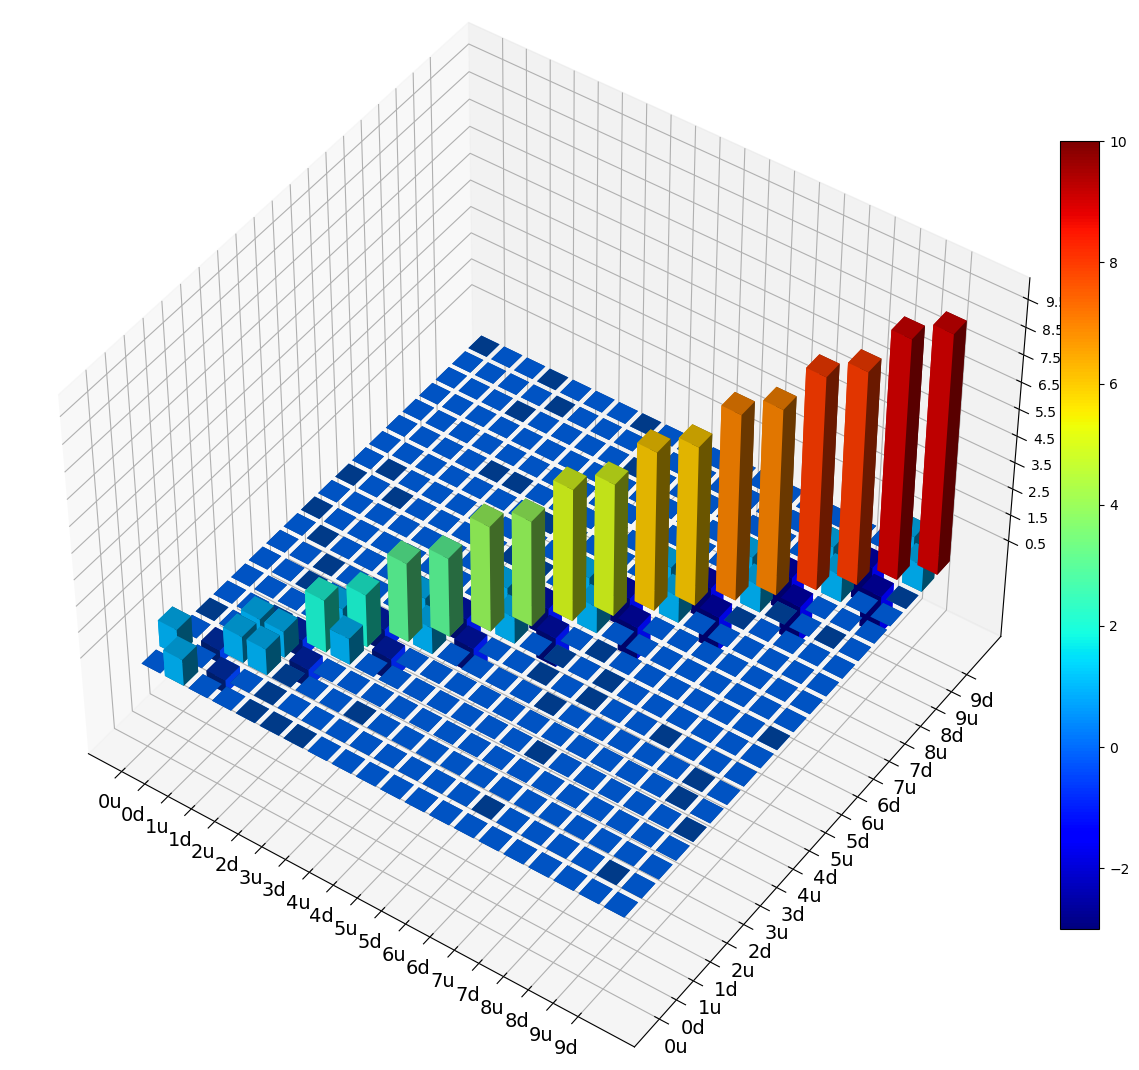

In [69]:
N = 10
a = tensor(destroy(N), qeye(2))
b = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())

H = a.dag() * a + sx - 0.5 * (a * b.dag() + a.dag() * b)

# visualize H

lbls_list = [[str(d) for d in range(N)], ["u", "d"]]
xlabels = []

for inds in tomography._index_permutations([len(lbls) for lbls in lbls_list]):
     xlabels.append("".join([lbls_list[k][inds[k]]
                            for k in range(len(lbls_list))])) 
        
fig, ax = matrix_histogram(H, xlabels, xlabels, limits=[-3,10])
ax.view_init(azim=-55, elev=45)
fig.set_size_inches(18.5, 10.5)
plt.show()